# Table of Contents

1. [Business Understanding](#Business-Understanding)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Model Building](#Model-Building)
5. [Productivization Plan](#Productivization-Plan)

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold

from sklearn.ensemble import StackingClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score

from category_encoders import OrdinalEncoder, LeaveOneOutEncoder

# from tensorflow import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.metrics import log_loss, accuracy_score, roc_auc_score, make_scorer

import joblib
import pickle

# Business Understanding
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

Given a set of features, we are asked to <b>predict whether or not a given household is poor or not</b>. This is a binary classification, which specifically posits the following problem: what is the <b>probability</b> of a given household of being poor. This probability is actually the prediction value and the loss function measures the prediction performance. For a binary classification, the typical loss function is the binary cross-entropy or <b>log loss</b>.<br>

Log Loss is a slight twist on the Likelihood Function. In fact, Log Loss is -1 * the log of the likelihood function. The likelihood function answers the question "How likely did the model think the actually observed set of outcomes was" and is computed iteratively stepping through all predictions by multiplying the probability associated with the actual outcome and subsequently by the previous result.<br>

Predictions ranging between 0 and 1, if you multiply enough numbers in this range, the result gets so small that computers can't keep track of it. So, as a clever computational trick, we instead keep track of the log of the Likelihood. We multiply this by negative 1 to maintain a common convention that lower loss scores are better. Lower loss scores are associated with higher probabilities and viceversa<br>

Since data is anonimized and no context information has been provided, no economic analysis is possible.

# Exploratory Data Analysis
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Load Data

In [4]:
# Train dataset
data_train = pd.read_csv('../data/Exercise_train (1).csv', sep=',')
data_train.head()

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
0,2225,29252,KfoTG,zPfZR,DtMvg,NaN,12.0,-3.0,-1.0,0.5,False
1,1598,98286,ljBjd,THHLT,DtMvg,esAQH,21.0,-2.0,-5.0,-9.5,True
2,7896,49040,Lsuai,zPfZR,zeYAm,ZCIYy,12.0,-3.0,-5.0,-9.5,True
3,1458,35261,KfoTG,mDadf,zeYAm,ZCIYy,12.0,-1.0,-5.0,-9.5,False
4,1817,98833,KfoTG,THHLT,DtMvg,ARuYG,21.0,-4.0,-5.0,-9.5,True


In [5]:
# Test dataset
data_test = pd.read_csv('../data/Exercise_test (1).csv', sep=',')
data_test.head()

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor
0,2197,42706,qzGkS,zPfZR,rXCdD,IJnCs,21.0,-3.0,-5.0,-9.5,False
1,4823,65531,KfoTG,THHLT,DtMvg,XHmQd,21.0,-2.0,-9.0,-19.5,True
2,4165,64452,tnDpM,THHLT,qTmDg,yygvO,30.0,-4.0,-9.0,-19.5,True
3,4962,78022,NaN,WXYiE,DtMvg,XAmOF,21.0,-2.0,3.0,10.5,False
4,4671,45674,Lsuai,zPfZR,DtMvg,hmAUm,30.0,-4.0,-5.0,-9.5,True


In [3]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6562 entries, 0 to 6561
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  6562 non-null   int64  
 1   id          6562 non-null   int64  
 2   kjkrfgld    6366 non-null   object 
 3   bpowgknt    6357 non-null   object 
 4   raksnhjf    6381 non-null   object 
 5   vwpsxrgk    6364 non-null   object 
 6   omtioxzz    6361 non-null   float64
 7   yfmzwkru    6353 non-null   float64
 8   tiwrsloh    6355 non-null   float64
 9   weioazcf    6366 non-null   float64
 10  poor        6562 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(4)
memory usage: 519.2+ KB


In [8]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1641 entries, 0 to 1640
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  1641 non-null   int64  
 1   id          1641 non-null   int64  
 2   kjkrfgld    1595 non-null   object 
 3   bpowgknt    1592 non-null   object 
 4   raksnhjf    1605 non-null   object 
 5   vwpsxrgk    1596 non-null   object 
 6   omtioxzz    1587 non-null   float64
 7   yfmzwkru    1597 non-null   float64
 8   tiwrsloh    1601 non-null   float64
 9   weioazcf    1579 non-null   float64
 10  poor        1641 non-null   bool   
dtypes: bool(1), float64(4), int64(2), object(4)
memory usage: 129.9+ KB


In both datasets, we encounter:
<ul>
    <li> same number of non-null values in the Unnamed: 0 column (supposedly, individuals <code>iid</code>) and households <code>id</code>, so that individuals analysis becomes irrelevant</li>
    <li> four possible categorical (nominal) variables represented as object (strings) with missing values both in train and in test(around 3% of each dataset)</li>
    <li> four continuous variables represented as float, with missing values both in train and in test(around 3% of each dataset)</li>
    <li> target variable represented as a boolean</li>
</ul>

#### No duplicates / Unique observations

In [17]:
column_names = [x for x in data_train.columns]
duplicates = data_train.duplicated(subset=column_names, keep=False)
data_train[duplicates]

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor


In [7]:
data_train.id.nunique() 

6562

In [9]:
column_names = [x for x in data_test.columns]
duplicates = data_test.duplicated(subset=column_names, keep=False)
data_test[duplicates]

,Unnamed: 0,id,kjkrfgld,bpowgknt,raksnhjf,vwpsxrgk,omtioxzz,yfmzwkru,tiwrsloh,weioazcf,poor


In [8]:
data_test.id.nunique()

1641

In [6]:
data_train = data_train.set_index('id')
data_test = data_test.set_index('id')

## Target

<AxesSubplot:title={'center':'Number of Poor'}>

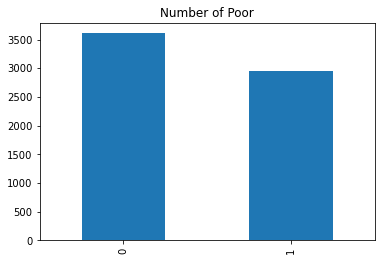

In [150]:
data_train.poor.value_counts().plot.bar(title='Number of Poor')

<AxesSubplot:title={'center':'Number of Poor'}>

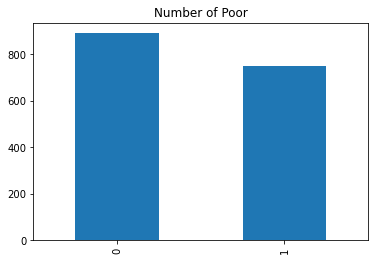

In [151]:
data_test.poor.value_counts().plot.bar(title='Number of Poor')

## Numerical features

In [26]:
data_train.describe()

,Unnamed: 0,omtioxzz,yfmzwkru,tiwrsloh,weioazcf
count,6562.000000,6361.000000,6353.000000,6355.000000,6366.000000
mean,4113.757543,17.455117,-2.826696,-4.194335,-7.461828
std,2353.382080,10.924393,12.615775,4.476410,11.198626
min,0.000000,-127.000000,-4.000000,-31.000000,-74.500000
25%,2088.500000,12.000000,-4.000000,-7.000000,-14.500000
50%,4115.500000,12.000000,-3.000000,-3.000000,-4.500000
75%,6156.750000,21.000000,-2.000000,-1.000000,0.500000
max,8202.000000,111.000000,1000.000000,3.000000,10.500000


Descriptive statistics of the four numerical variables uncover the following:
<ul>
    <li>there are missing values</li>
    <li>skewed distributions and presence of outliers</li>
</ul>

## Categorical features

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


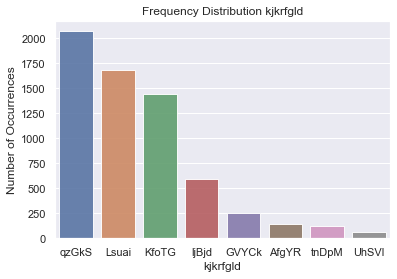

In [15]:
kjkrfgld_count = cat_data_train['kjkrfgld'].value_counts()
sns.set(style="darkgrid")
sns.barplot(kjkrfgld_count.index, kjkrfgld_count.values, alpha=0.9)
plt.title('Frequency Distribution kjkrfgld')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('kjkrfgld', fontsize=12)
plt.show()

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


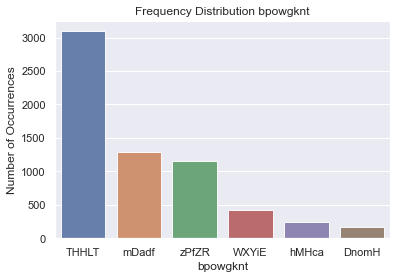

In [62]:
bpowgknt_count = cat_data_train['bpowgknt'].value_counts()
sns.set(style="darkgrid")
sns.barplot(bpowgknt_count.index, bpowgknt_count.values, alpha=0.9)
plt.title('Frequency Distribution bpowgknt')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('bpowgknt', fontsize=12)
plt.show()

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


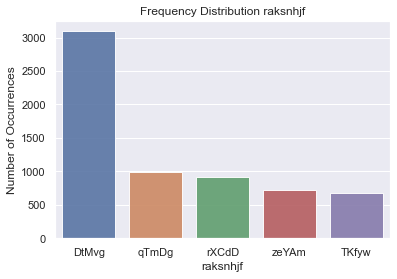

In [64]:
raksnhjf_count = cat_data_train['raksnhjf'].value_counts()
sns.set(style="darkgrid")
sns.barplot(raksnhjf_count.index, raksnhjf_count.values, alpha=0.9)
plt.title('Frequency Distribution raksnhjf')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('raksnhjf', fontsize=12)
plt.show()

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


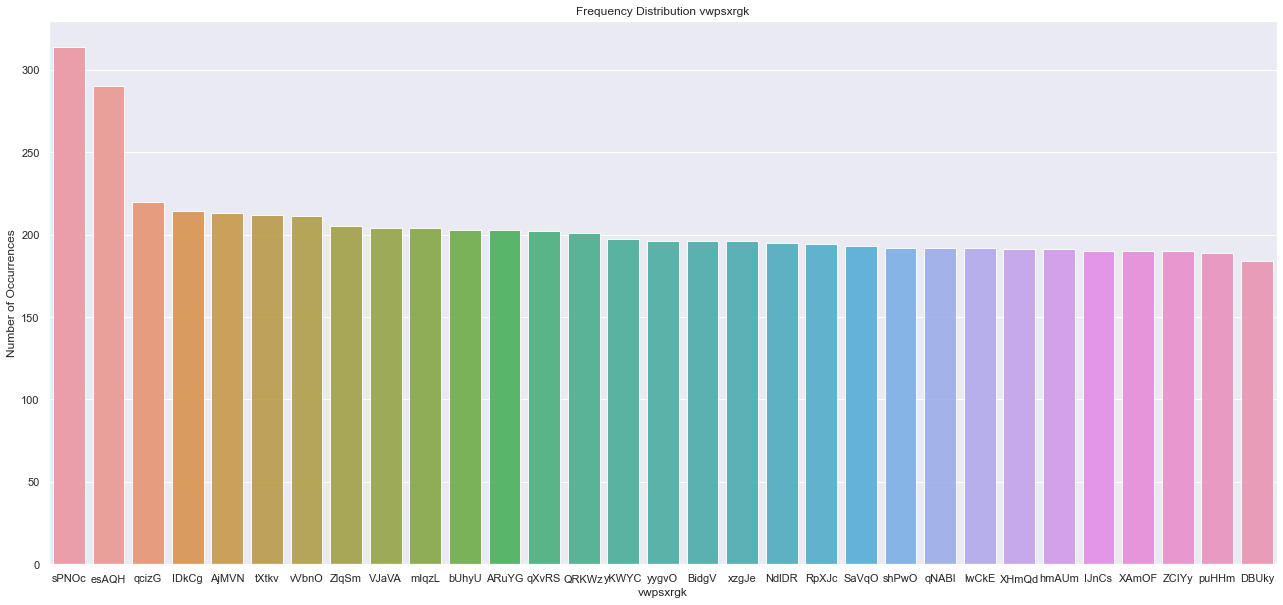

In [68]:
vwpsxrgk_count = cat_data_train['vwpsxrgk'].value_counts()
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(22,10)})
sns.barplot(vwpsxrgk_count.index, vwpsxrgk_count.values, alpha=0.9)
plt.title('Frequency Distribution vwpsxrgk')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('vwpsxrgk', fontsize=12)
plt.show()

# Data Preprocessing
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Target preprocessing

Let's transform our target variable into a binary (0, 1) variable.

In [7]:
data_train['poor'] = data_train['poor'].apply(lambda x: 1 if x == True else 0)

In [8]:
data_test['poor'] = data_test['poor'].apply(lambda x: 1 if x == True else 0)

## Train, Test datasets

In [9]:
X_train = data_train.drop('poor', 1)
y_train = data_train['poor']

In [10]:
X_test = data_test.drop('poor', 1)
y_test = data_test['poor']

## Features preprocessing

Data preprocessing can be embedded in a data pipeline. To be noted that Ordinal Encoder (category_encoders) in a pipeline would have resolved both NA imputation and ordinal categorical encoding. In the previous section, we used <i>out-of-the-pipe</i> scikit-learn's Ordinal Encoder to convert non-missing categorical columns to ordinal values only before imputing NAs (and ultimately converting categories back to strings).<br>

However, there is a data preprocessing's last step, namely categorical feature encoding that, for a matter of simplicity, will be tackled with a column transform and plugged into a model pipeline.<br>

We will opt for an ordinal encoder for those variables with a low dimensionality (and coincidentally, uneven frequency distribution among categories) and for a target encoder for the variable with a greater dimensionality. With target encoding, each category is replaced with the mean target value for samples having that category. This prevents increasing the dimensionality of our data but it also captures correlations in target values, which is precisely the source of overfitting. This should be carefully addressed; as such, we will train sigma variable of target encoder (or the noise). 

Check for reference this [video](https://www.youtube.com/watch?v=Ma-CDFLd03g) (1:17 min onwards) and this [tutorial](https://www.datacamp.com/community/tutorials/categorical-data). For more information on target encoding, read this [post](https://brendanhasz.github.io/2019/03/04/target-encoding).<br>

In [11]:
# Categorical features: (i) ordinal encoder for low dimensionality categorical variables (which implicitely impute NAs)
low_dim_cat = ['kjkrfgld', 'bpowgknt', 'raksnhjf']
ordinal_enc = OrdinalEncoder()

# Categorical features (suite): (ii) target encoder for the high dimensionality categorical variable (it also tackles NAs imputation)
high_dim_cat = ['vwpsxrgk']
target_enc = LeaveOneOutEncoder()
    
# Numerical features: (i) impute NAs using median strategy, (ii) scale data using Power Transformer to properly address for skewed distributions and outliers
numeric_features = data_train.select_dtypes(include=['float64']).columns.copy()
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', PowerTransformer())])

# Preprocessor with a Column Transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('ordinal_encoder', ordinal_enc, low_dim_cat),
        ('target_encoder', target_enc, high_dim_cat)])

# Model Building
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

## Baseline model: Logistic Regression

In [56]:
# Logistic Regression
clf = LogisticRegression()
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier',  clf)])

lr = pipe.fit(X_train, y_train)

pipe.predict(X_test)

y_pred = pipe.predict_proba(X_test)
log_loss(y_test, y_pred, eps=1e-15, normalize=True, sample_weight=None, labels=None)


0.5165545774500514

## Random Forest Classifier

From now on, we will perform some hyperparameter tuning and cross-validation.<br>
Explain about noise in target encoder.

In [13]:
clf_rf = RandomForestClassifier()
pipe_rf = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_rf)])

In [14]:
# Hyperparameters can be accessed with a double underscore
param_grid = {
    'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
    'classifier__bootstrap': [True],
    'classifier__max_depth': [80, 90, 100, 110],
    'classifier__max_features': [2, 3],
    'classifier__min_samples_leaf': [3, 4, 5],
#     'classifier__min_samples_split': [8, 10, 12],
    'classifier__n_estimators': [100, 200, 300, 1000]
}

rscv_rf = RandomizedSearchCV(pipe_rf,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid,
                          scoring='neg_log_loss',
                          random_state=1)


In [68]:
cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='neg_log_loss')

array([-0.5599944 , -0.57126105, -0.60031365, -0.58997122, -0.60401031])

In [38]:
rf_fit = rscv_rf.fit(X_train, y_train)
rf_fit

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [16]:
rscv_rf.best_params_

{'preprocessor__target_encoder__sigma': 0.02,
 'classifier__n_estimators': 300,
 'classifier__min_samples_leaf': 4,
 'classifier__max_features': 2,
 'classifier__max_depth': 80,
 'classifier__bootstrap': True}

In [17]:
rscv_rf.best_score_

-0.49623545803375035

Metrics [Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.log_loss.html#sklearn.metrics.log_loss)

In [18]:
y_pred_rf = rscv_rf.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_rf, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.4976755244147369

## Gradient Boosting Methods

[Read](https://machinelearningmastery.com/gradient-boosting-with-scikit-learn-xgboost-lightgbm-and-catboost/) on methods' differences.

### Extreme Gradient Boosting

In [19]:
clf_xgb = XGBClassifier()
pipe_xgb = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_xgb)])

In [20]:
# Hyperparameters can be accessed with a double underscore
param_grid_XGB = {
        'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__max_depth' : [3, 4, 5],
#         'classifier__objective' : 'binary:logistic',
#         'classifier__silent' : True,
#         'classifier__gamma' : 0.3,
#         'classifier__subsample' : 0.7,
#         'classifier__reg_alpha' : 0.05
}

rscv_xgb = RandomizedSearchCV(pipe_xgb,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid_XGB,
                          scoring='neg_log_loss',
                          random_state=1)

In [39]:
xgb_fit = rscv_xgb.fit(X_train, y_train)
xgb_fit

/home/isabel/anaconda3/envs/DD_Pover-T_Tests/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[18:39:10] WARNING: /home/conda/feedstock_root/build_artifacts/xgboost_1607604574104/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [22]:
rscv_xgb.best_params_

{'preprocessor__target_encoder__sigma': 0.03,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 5,
 'classifier__learning_rate': 0.01}

In [23]:
rscv_xgb.best_score_

-0.4998994450134585

In [24]:
y_pred_xgb = rscv_xgb.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_xgb, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.501031834830795

### Light Gradient Boosting

[Hyperparameter tunning](https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html)

In [25]:
clf_lgb = LGBMClassifier()
pipe_lgb = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_lgb)])

In [26]:
# Hyperparameters can be accessed with a double underscore
param_grid_LGB = {
        'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__max_depth' : [6, 7, 8],
        'classifier__l2_leaf_reg' : [3, 4, 5],
#         'classifier__loss_function' : 'Logloss',
#         'classifier__silent' : True,
#         'classifier__boosting_type' : 'gbdt',
#         'classifier__objective' : 'binary',
#         'classifier__gamma' : 0.3,
#         'classifier__subsample' : 0.6,
#         'classifier__reg_alpha' : 0.02,
#         'classifier__is_unbalance' : True,
#         'classifier__reg_lambda' : 0.01,
}

rscv_lgb = RandomizedSearchCV(pipe_lgb,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid_LGB,
                          scoring='neg_log_loss',
                          random_state=1)

In [41]:
lgb_fit = rscv_lgb.fit(X_train, y_train)
lgb_fit

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [28]:
rscv_lgb.best_params_

{'preprocessor__target_encoder__sigma': 0.02,
 'classifier__n_estimators': 300,
 'classifier__max_depth': 7,
 'classifier__learning_rate': 0.01,
 'classifier__l2_leaf_reg': 3}

In [29]:
rscv_lgb.best_score_

-0.49621701720734324

In [30]:
y_pred_lgb = rscv_lgb.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_lgb, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.4975177479683505

### CatBoost

In [31]:
clf_cb = CatBoostClassifier()
pipe_cb = Pipeline([('preprocessor', preprocessor), ('classifier',  clf_cb)])

Hyperparameters tunning [Documentation](https://catboost.ai/docs/concepts/python-reference_parameters-list.html)

In [32]:
# Hyperparameters can be accessed with a double underscore
param_grid_CB = {
        'preprocessor__target_encoder__sigma': [0.01, 0.02, 0.03, 0.04, 0.05, 0.06],
        'classifier__n_estimators': [100, 200, 300, 1000],
        'classifier__learning_rate' : [0.01, 0.02, 0.03],
        'classifier__depth' : [6, 7, 8],
        'classifier__l2_leaf_reg' : [3, 4, 5],
#         'classifier__loss_function' : 'Logloss',
#         'classifier__logging_level' : 'Silent',
}

rscv_cb = RandomizedSearchCV(pipe_cb,
                          cv=5,
                          n_iter=5,
                          n_jobs=10,
                          param_distributions = param_grid_CB,
                          scoring='neg_log_loss',
                          random_state=1)

In [42]:
cb_fit = rscv_cb.fit(X_train, y_train)
cb_fit

0:	learn: 0.6892266	total: 2.94ms	remaining: 2.94s
1:	learn: 0.6852680	total: 5.78ms	remaining: 2.88s
2:	learn: 0.6815974	total: 8.46ms	remaining: 2.81s
3:	learn: 0.6777878	total: 11.2ms	remaining: 2.78s
4:	learn: 0.6740181	total: 13.8ms	remaining: 2.75s
5:	learn: 0.6705922	total: 16.5ms	remaining: 2.73s
6:	learn: 0.6671515	total: 19.2ms	remaining: 2.72s
7:	learn: 0.6636360	total: 24.1ms	remaining: 2.99s
8:	learn: 0.6604588	total: 26.9ms	remaining: 2.96s
9:	learn: 0.6573361	total: 29.6ms	remaining: 2.93s
10:	learn: 0.6541495	total: 32.3ms	remaining: 2.9s
11:	learn: 0.6513206	total: 34.9ms	remaining: 2.88s
12:	learn: 0.6483316	total: 37.6ms	remaining: 2.85s
13:	learn: 0.6456917	total: 40.3ms	remaining: 2.84s
14:	learn: 0.6426534	total: 43ms	remaining: 2.82s
15:	learn: 0.6398176	total: 45.7ms	remaining: 2.81s
16:	learn: 0.6375460	total: 48.3ms	remaining: 2.79s
17:	learn: 0.6348912	total: 50.9ms	remaining: 2.78s
18:	learn: 0.6322881	total: 53.7ms	remaining: 2.77s
19:	learn: 0.6296289	tota

166:	learn: 0.4944086	total: 396ms	remaining: 1.97s
167:	learn: 0.4941303	total: 401ms	remaining: 1.98s
168:	learn: 0.4938156	total: 404ms	remaining: 1.99s
169:	learn: 0.4935129	total: 408ms	remaining: 1.99s
170:	learn: 0.4932132	total: 411ms	remaining: 1.99s
171:	learn: 0.4930864	total: 414ms	remaining: 1.99s
172:	learn: 0.4927961	total: 418ms	remaining: 2s
173:	learn: 0.4924777	total: 426ms	remaining: 2.02s
174:	learn: 0.4921739	total: 430ms	remaining: 2.03s
175:	learn: 0.4919066	total: 434ms	remaining: 2.03s
176:	learn: 0.4916039	total: 439ms	remaining: 2.04s
177:	learn: 0.4913073	total: 445ms	remaining: 2.05s
178:	learn: 0.4910215	total: 448ms	remaining: 2.05s
179:	learn: 0.4907252	total: 450ms	remaining: 2.05s
180:	learn: 0.4903993	total: 453ms	remaining: 2.05s
181:	learn: 0.4902356	total: 456ms	remaining: 2.05s
182:	learn: 0.4900569	total: 459ms	remaining: 2.05s
183:	learn: 0.4898594	total: 461ms	remaining: 2.04s
184:	learn: 0.4895940	total: 463ms	remaining: 2.04s
185:	learn: 0.4

405:	learn: 0.4546895	total: 986ms	remaining: 1.44s
406:	learn: 0.4545813	total: 989ms	remaining: 1.44s
407:	learn: 0.4544556	total: 994ms	remaining: 1.44s
408:	learn: 0.4543806	total: 1000ms	remaining: 1.44s
409:	learn: 0.4542714	total: 1s	remaining: 1.45s
410:	learn: 0.4541963	total: 1.01s	remaining: 1.44s
411:	learn: 0.4540787	total: 1.01s	remaining: 1.44s
412:	learn: 0.4539339	total: 1.01s	remaining: 1.44s
413:	learn: 0.4538526	total: 1.01s	remaining: 1.44s
414:	learn: 0.4537236	total: 1.02s	remaining: 1.43s
415:	learn: 0.4535871	total: 1.02s	remaining: 1.43s
416:	learn: 0.4534716	total: 1.02s	remaining: 1.43s
417:	learn: 0.4533704	total: 1.02s	remaining: 1.43s
418:	learn: 0.4533157	total: 1.03s	remaining: 1.42s
419:	learn: 0.4532005	total: 1.03s	remaining: 1.42s
420:	learn: 0.4531197	total: 1.03s	remaining: 1.42s
421:	learn: 0.4530198	total: 1.03s	remaining: 1.41s
422:	learn: 0.4529348	total: 1.03s	remaining: 1.41s
423:	learn: 0.4528278	total: 1.04s	remaining: 1.41s
424:	learn: 0.

568:	learn: 0.4401747	total: 1.38s	remaining: 1.05s
569:	learn: 0.4401148	total: 1.39s	remaining: 1.04s
570:	learn: 0.4400670	total: 1.39s	remaining: 1.04s
571:	learn: 0.4399390	total: 1.39s	remaining: 1.04s
572:	learn: 0.4398147	total: 1.39s	remaining: 1.04s
573:	learn: 0.4397288	total: 1.4s	remaining: 1.03s
574:	learn: 0.4396881	total: 1.4s	remaining: 1.03s
575:	learn: 0.4396597	total: 1.4s	remaining: 1.03s
576:	learn: 0.4395788	total: 1.41s	remaining: 1.03s
577:	learn: 0.4394395	total: 1.41s	remaining: 1.03s
578:	learn: 0.4393786	total: 1.41s	remaining: 1.03s
579:	learn: 0.4393346	total: 1.42s	remaining: 1.02s
580:	learn: 0.4392394	total: 1.42s	remaining: 1.02s
581:	learn: 0.4392308	total: 1.42s	remaining: 1.02s
582:	learn: 0.4391925	total: 1.42s	remaining: 1.02s
583:	learn: 0.4391717	total: 1.43s	remaining: 1.01s
584:	learn: 0.4391315	total: 1.43s	remaining: 1.01s
585:	learn: 0.4390726	total: 1.43s	remaining: 1.01s
586:	learn: 0.4389843	total: 1.43s	remaining: 1.01s
587:	learn: 0.4

802:	learn: 0.4243572	total: 1.98s	remaining: 485ms
803:	learn: 0.4242663	total: 1.98s	remaining: 483ms
804:	learn: 0.4242194	total: 1.98s	remaining: 481ms
805:	learn: 0.4241485	total: 1.99s	remaining: 479ms
806:	learn: 0.4240701	total: 1.99s	remaining: 476ms
807:	learn: 0.4239915	total: 1.99s	remaining: 474ms
808:	learn: 0.4239119	total: 2s	remaining: 471ms
809:	learn: 0.4238569	total: 2s	remaining: 469ms
810:	learn: 0.4237392	total: 2s	remaining: 466ms
811:	learn: 0.4237046	total: 2s	remaining: 464ms
812:	learn: 0.4236162	total: 2.01s	remaining: 462ms
813:	learn: 0.4235797	total: 2.01s	remaining: 459ms
814:	learn: 0.4234900	total: 2.01s	remaining: 457ms
815:	learn: 0.4234395	total: 2.02s	remaining: 454ms
816:	learn: 0.4233440	total: 2.02s	remaining: 452ms
817:	learn: 0.4232387	total: 2.02s	remaining: 449ms
818:	learn: 0.4231292	total: 2.02s	remaining: 447ms
819:	learn: 0.4230897	total: 2.02s	remaining: 444ms
820:	learn: 0.4230340	total: 2.03s	remaining: 442ms
821:	learn: 0.4229595	to

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               Pipeline(steps=[('imputer',
                                                                                                SimpleImputer(strategy='median')),
                                                                                               ('scaler',
                                                                                                PowerTransformer())]),
                                                                               Index(['omtioxzz', 'yfmzwkru', 'tiwrsloh', 'weioazcf'], dtype='object')),
                                                                              ('ordinal_encoder',
                                                                               OrdinalEncoder(),
                

In [34]:
rscv_cb.best_params_

{'preprocessor__target_encoder__sigma': 0.02,
 'classifier__n_estimators': 1000,
 'classifier__learning_rate': 0.01,
 'classifier__l2_leaf_reg': 3,
 'classifier__depth': 7}

In [35]:
rscv_cb.best_score_

-0.48449509401353297

In [36]:
y_pred_cb = rscv_cb.best_estimator_.predict_proba(X_test)
log_loss(y_test, y_pred_cb, eps=1e-15, normalize=True, sample_weight=None, labels=None)

0.48796665517308857

## Ensembling Models

<b>Figure 1</b>: <b>Ensembling Arquitecture</b> (<i>source: [Datacamp](https://www.datacamp.com/resources/webinars/applied-machine-learning-stacking-ensemble-models?utm_medium=email&utm_source=customerio&utm_campaign=livetraining&utm_id=3679156))</i>)<br>
<p align="center">
<img src="https://github.com/datacamp/Applied-Machine-Learning-Ensemble-Modeling-live-training/blob/master/assets/stacking.png?raw=True" alt = "Stacking" width="90%">
</p>
<br><br>

Check [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html) for more information.

In [59]:
estimators = [
    ('rf', pipe_rf),
    ('xgb', pipe_xgb),
    ('lgb', pipe_lgb),
    ('cb', pipe_cb)
]

clf_stack = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), cv=5, stack_method='predict_proba', n_jobs=-1
)

clf_stack.fit(X_train, y_train).score(X_test, y_test)

0.7416209628275442

In [62]:
estimators = [
    ('rf', rscv_rf),
    ('xgb', rscv_xgb),
    ('lgb', rscv_lgb),
    ('cb', rscv_cb)
]

clf_stack = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(), cv=5, stack_method='predict_proba', n_jobs=-1
)

clf_stack.fit(X_train, y_train).score(X_test, y_test)

0.7428397318708104

## A Neural Network model for binary classification

Check this DataCamp [course](https://learn.datacamp.com/courses/deep-learning-with-keras-in-python) for more information.<br>

However, an unresolved Attribute error pops up while importing tensorflow / keras libraries ([GitHub issue](https://github.com/tensorflow/tensorflow/issues/38012)). Unluckily, this solution (python 3.6) is not valid for python 3.8. Therefore, this neural network could not be fitted.

In [119]:
# Function that creates a Keras model
def create_model(optimizer='sgd', activation='tanh'):
    model = Sequential()
    model.add(Dense(4, input_shape=(2,), activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy')
    return model
    
# Create a model a sklearn estimator
model = KerasClassifier(build_fn=create_model, epochs=6, batch_size=16)
    
# Plug the model into the pipeline
pipe = Pipeline([('column_transform', column_trans), ('classifier', model)])
    
# Random search on a Keras model
params = dict(optimizer=['sgd', 'adam'], epochs=3,
              batch_size=[5, 10, 20], activation=['tanh', 'LeakyReLU']
              
rscv_nn = RandomizedSearchCV(pipe, params_dist=params, cv=3)
              
# Model fit
rscv_nn.fit(X_train, y_train)
              
rscv_nn.best_scores_
rscv_nn.best_params_
              

SyntaxError: invalid syntax (<ipython-input-119-252077236823>, line 19)

In [ ]:
# Model test
y_pred_nn = model.predict_proba(X_test)

test_loss, test_acc = model.evaluate(X_test, y_test)
print('Test accuracy: {}, Test loss: {}'.format(test_acc, test_loss))

## Save results in .csv file

In [72]:
y_pred_cb

array([[0.60399086, 0.39600914],
       [0.48768158, 0.51231842],
       [0.36755581, 0.63244419],
       ...,
       [0.93259486, 0.06740514],
       [0.30439007, 0.69560993],
       [0.60212311, 0.39787689]])

In [123]:
index = data_test.reset_index().id
results = pd.DataFrame(index=index)
results['poor'] = y_pred_cb[:, 1]

In [129]:
results.tail()

,poor
id,
30092,0.758359
38226,0.415584
36893,0.067405
97193,0.695610
83638,0.397877


In [130]:
results.to_csv('../model/results.csv')

# Productivization Plan
<div style = "float:right"><a style="text-decoration:none" href = "#inicio">Inicio</a></div>

After building a model in lab conditions, we shall export a copy of it to the production server, where new data will be labelled. This process is called model deployment or pushing to production. To enable this, we shall serialize our model, that is, convert it to a binary file with pickle.<br>

As proceeded, we encapsulate the whole process into a single object (pipeline) to interact with production unless we want to repeat one or various processes in production. We shall aim at avoiding bugs which can eventually cause financial problems.

<b>Figure 1</b>: <b>Model Deployment</b> (<i>source: [Datacamp](https://learn.datacamp.com/courses/designing-machine-learning-workflows-in-python)</i>)<br>
<p align="center">
<img src="../images/model_deployment.png">

Save pickle file in write mode.

In [67]:
with open('../model/model.pkl', 'wb') as file:
    pickle.dump(rscv_cb.best_estimator_, file=file)

Load pickle file in read mode.

In [68]:
with open('../model/model.pkl', 'rb') as file:
    clf2 = pickle.load(file)